# 标准方程

$\hat{\theta} = ((X^{T} \cdot X)^{-1}\cdot X^{T} \cdot y)$

In [258]:
# 随机生成一些数据来测试标准方程
import numpy as np
X = 2*np.random.rand(100, 1)
y = 4+ 3*X+np.random.randn(100, 1)

In [223]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [246]:
theta_best

array([[4.17795097],
       [2.87092976]])

我们期待的是[4,3]，由于高斯噪音的存在有些误差。

In [225]:
#用model做出预测
X_new = np.array([[0], [2],[1.5]])
X_new_b = np.c_[np.ones((3,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.17795097],
       [9.91981048],
       [8.4843456 ]])

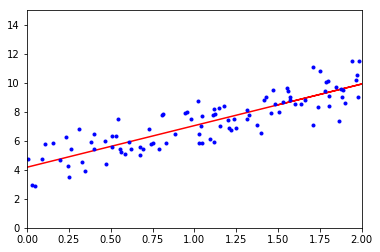

In [226]:
import matplotlib.pyplot as plt
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

In [227]:
# scikit-learn的等效代码，得到同样的结果
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.17795097]), array([[2.87092976]]))

### 计算复杂度
$X^{T}X$是一个nXn矩阵（n是特征数量）， 对矩阵求逆的复杂度通常为$O(n^{2.4})到O(n^3)$。  
对于训练集数量，复杂度是线性的。

### 梯度下降

线性回归模型的ＭＳＥ是凸函数。  
虽然代价函数是凸函数，但如果不同特征的尺寸相差太多，可能是一个非常细长的碗，这样收敛时间会长很多。  
scikit-learn的StandardScalar类可以做标准化的特征放缩来解决这个问题。

### BGD

In [228]:
learning_rate = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)     #random initialization

theta_path_ｂgd = []
for iteration in range(n_iterations):
    gradients = 2/m*X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - learning_rate*gradients
    theta_path_ｂgd.append(theta) 

In [229]:
theta

array([[4.17795097],
       [2.87092976]])

### SGD

In [230]:
theta_path_sgd = []
n_epoches = 50
t0,t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)   # random initialization

for epoch in range(n_epoches):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index+1]
        yi = y[random_index: random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta-eta*gradients
        theta_path_sgd.append(theta)  

theta        

array([[4.17152314],
       [2.87492108]])

In [231]:
# 使用scikit-learn的SGDRegression类。
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0 = 0.1)   #运行50轮，（每轮m次更新gradient）；没使用任何正则化；默认的学习计划，学习率从0.1开始。
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=50, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [232]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21524122]), array([2.91920992]))

### Mini-batch gradient descent

In [233]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [234]:
ｔｈｅｔａ

array([[4.15518825],
       [2.86894633]])

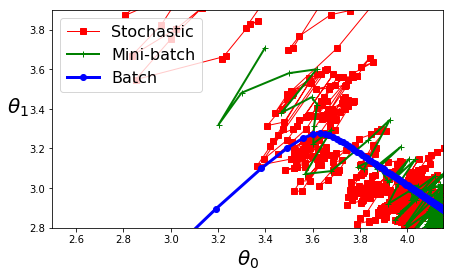

In [235]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.15, 2.8, 3.9])
plt.show()

### 多项式回归

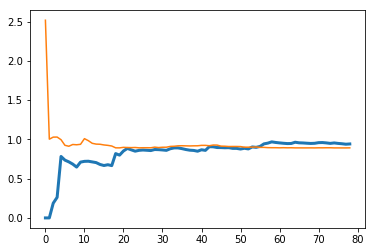

In [236]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        test_errors.append(mean_squared_error(y_test_predict, y_test))
    plt.plot(np.sqrt(train_errors), label="train", linewidth=3)
    plt.plot(np.sqrt(test_errors), label="test")
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y)

更多的训练集没用。

[0, 80, 0, 3]

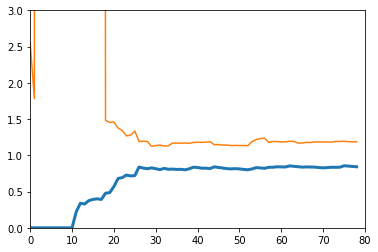

In [237]:
# 观察 在10阶多项式上模型的learning curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_regression = Pipeline((
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("sgd_reg", LinearRegression()),
))
plot_learning_curve(poly_regression, X, y)
plt.axis([0,80,0,3])

两条曲线收敛值差得多，这是过拟合的标志，更大训练集会让两条线更加接近。

<br>

# 正则线性模型

### 岭回归

$J(\theta)=MSE(\theta)+\alpha \frac{1}{2}\sum_{i=1}^n \theta_i^2$

闭式解的岭回归：
$\hat{\theta}=(X^{T} \cdot X+\alpha A)^{-1} \cdot X^{T} \cdot y$

In [263]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")            #利用andre-louis cholesky的矩阵因式分解法
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[8.37320339]])

使用梯度下降发： 

In [254]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

C:\Users\peter\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([8.33850775])

### 套索（Lasso）回归

$J(\theta)=MSE(\theta)+\alpha \frac{1}{2}\sum_{i=1}^n |\theta_i|$

Lasso回归倾向于完全消除最不重要的特征，也就是将他们的权重设置为0。<br>
Lasso回归会自动执行特征选择并输出一个稀疏模型（只有很少的特征有非零权重）。<br>
当特征数量超过训练实例数量时，又或者几个特征强相关时，Lasso回归的表现不稳定。

In [268]:
# 一个使用scikit-learn的Lasso类的例子
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([8.2447712])

In [267]:
#使用SDGRegressor, penalty属性是"l1"
lasso_reg = SGDRegressor(alpha=0.1, penalty="l1")
lasso_reg.fit(X,y.ravel())
lasso_reg.predict([[1.5]])

C:\Users\peter\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([8.06520635])

<br>

### 弹性网络

其正则项是岭回归正则项和Lasso回归正则项的混合，混合比例通过r来控制。

$J(\theta)=MSE(\theta)+r \alpha \frac{1}{2}\sum_{i=1}^n |\theta_i|+\frac{1-r}{2} \alpha \frac{1}{2}\sum_{i=1}^n \theta_i^2$

如何在三种正则化回归中选择？<br>
岭回归是个不错的默认选择。如果觉得实际用到的特征只有少数几个时，倾向于Lasso回归或弹性回归。一般而言，弹性网络优于Lasso回归。

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net

# 早期停止法

In [ ]:
from sklearn.base import clone
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    